## Imports

In [1]:
import os
import csv
import xml.etree.ElementTree as ET
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import torch.nn.functional as F
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import ColorJitter
from torchvision.transforms import GaussianBlur
from matplotlib.patches import Rectangle
import torchvision.transforms.functional as TF
# from torchvision.transforms import functional as F
import matplotlib.patches as patches
import glob
import pickle
import random

import networkx as nx
import itertools

## Pickle

In [2]:
pickle_path = "C:/Users/Gaura/OneDrive/Desktop/GAURAV/Unimleb/COMP90051/"       ## Change this location
pickle_file_path = os.path.join(pickle_path, 'data.pkl')

# Load the pickle file
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

filenames = data['file_names']  # List of filenames
resized_images = data['images']  # Corresponding image tensors (resized)
object_location = data['object_locations'] # Corresponding to new bb co-ordinates

## Functions

In [3]:
torch_to_np = lambda tse : tse.permute(1, 2, 0).numpy()
np_to_torch = lambda npa : torch.from_numpy(npa).permute(2, 0, 1)

def show_image(pic, obj=False, convert=False, font_size=12):
    if isinstance(pic, torch.Tensor):
        pic = torch_to_np(pic)
    if convert:
        pic = image.imread(pic)
    
    pyplot.imshow(pic)
    
    if obj:
        labels = []
        bound_box = []
        for k, v in obj.items():
            labels.append(v[0])
            bound_box.append(v[1])
        
        # Draw bounding boxes and labels
        for i, bbox in enumerate(bound_box):
            x_min, y_min, x_max, y_max = bbox
            width, height = x_max - x_min, y_max - y_min
            
            # Add a rectangle patch for each bounding box
            rect = Rectangle((x_min, y_min), width, height, linewidth=3, edgecolor='red', facecolor='none')
            pyplot.gca().add_patch(rect)
            
            # Add text label above the bounding box
            pyplot.text(x_min, y_min - 5, labels[i], color='white', fontsize=font_size, 
                        bbox=dict(facecolor='red', edgecolor='red', pad=2.0))
    
    print(f"dtype : {pic.dtype}")
    print(f"Shape : {pic.shape}")
    print(f"Aspect Ratio (h/w) : {round(pic.shape[0] / pic.shape[1], 2)}")
    pyplot.show()

sorted_join = lambda st : "".join(sorted(list(set("".join(sorted(st))))))

get_area = lambda arbb : (arbb[2]-arbb[0])*(arbb[3]-arbb[1])

def calculate_intersection_area(box1, box2, get_intersection_box = False):
    # Box format: [x_min, y_min, x_max, y_max]
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2
    
    inter_x_min = max(x_min1, x_min2)
    inter_y_min = max(y_min1, y_min2)
    inter_x_max = min(x_max1, x_max2)
    inter_y_max = min(y_max1, y_max2)
    
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    
    intersection_area = inter_width * inter_height
    if (get_intersection_box):
        return intersection_area, [inter_x_min, inter_y_min, inter_x_max, inter_y_max]
        
    return intersection_area

## Graph

In [4]:
class Node:
    def __init__(self, label, box):
        self.label = label  
        self.box = box  
        self.area = self.calculate_area(box)  
        self.children = [] 
    
    def calculate_area(self, box):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        return width * height

    def add_child(self, child_node):
        self.children.append(child_node)  

    def __repr__(self):
        return f"Node({self.label}, Box: {self.box}, Area: {self.area}, Children: {[child.label for child in self.children]})"


class BoundingBoxGraph:
    def __init__(self):
        self.nodes = {}
    
    def add_node(self, label, box):
        node = Node(label, box)  
        self.nodes[label] = node 
    
    def add_edge(self, parent_label, child_label):
        if parent_label in self.nodes and child_label in self.nodes:
            self.nodes[parent_label].add_child(self.nodes[child_label])
    
    def display_graph(self):
        G = nx.DiGraph()

        for label, node in self.nodes.items():
            G.add_node(label, box=node.box, area=node.area)
            for child in node.children:
                G.add_edge(label, child.label)

        
        pos = nx.shell_layout(G)  
        # pos = nx.circular_layout(G)  
        # pos = nx.spring_layout(G)  
        # pos = nx.spectral_layout(G) 
        # pos = nx.spiral_layout(G) 
        # pos = nx.planar_layout(G) 

        box_labels = {node: f"Box: {self.nodes[node].box}" for node in self.nodes}
        area_labels = {node: f"Area: {self.nodes[node].area}" for node in self.nodes}

        nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=400, font_size=9, font_weight='bold', font_color='red',  horizontalalignment='right')
        nx.draw_networkx_labels(G, pos, labels=area_labels, font_size=8, verticalalignment='center_baseline', font_color='green', horizontalalignment='left')

        plt.show()
    
    def is_blood_line(self, nd1, nd2):
        nd1.children

    def get_nodes(self):
        return self.nodes
    
    def get_node_dict(self):
        n_dict = {}
        for nd in list(self.nodes.items()):
            n_dict[nd[0]] = nd[1]
        return n_dict


    def is_descendant(self, node1_label, node2_label):
        """
        Check if node1 is a descendant of node2.
        This function traverses the graph starting from node2 and looks for node1 in its children.
        """
        if node2_label not in self.nodes or node1_label not in self.nodes:
            return False  

        node2 = self.nodes[node2_label]
        
        def check_descendant(node, target_label):
            if node.label == target_label:
                return True
            for child in node.children:
                if check_descendant(child, target_label):
                    return True
            return False
        
        return check_descendant(node2, node1_label)

    def get_far_descendants(self, element):
        # Convert the input element to a set of characters
        element_set = set(element)
        
        descendants = []
        
        for item in self.get_nodes().keys():
            item_set = set(item)
            
            if element_set.issubset(item_set) and len(item_set) > len(element_set):
                descendants.append(item)
        
        return descendants

    
    def get_all_descendants(self, node_label):
        """
        Get all descendants of a node in a list.
        """
        if node_label not in self.nodes:
            return []  

        node = self.nodes[node_label]
        descendants = []

        def collect_descendants(node):
            for child in node.children:
                descendants.append(child.label)  
                collect_descendants(child)  

        collect_descendants(node)

        return descendants
        
    def print_graph(self):
        # Print all the nodes with their children
        for node in self.nodes.values():
            print(node)

## Sample Image

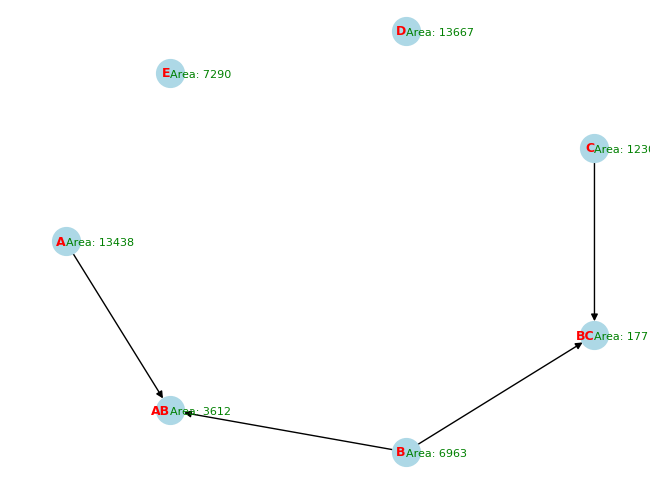

dtype : uint8
Shape : (584, 688, 3)
Aspect Ratio (h/w) : 0.85


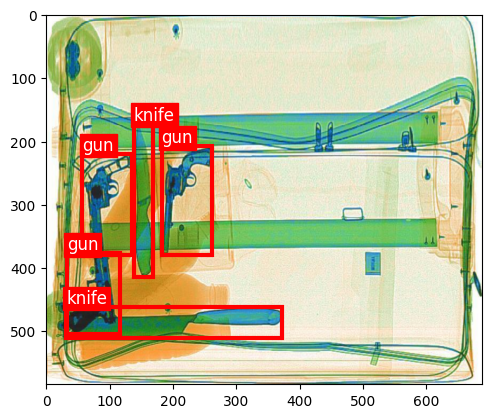

,poly_name,poly_area,Number_of_overlaps
0,knife0,13438,1
1,gun1,6963,1
2,gun2,12303,1
3,gun3,13667,1
4,knife4,7290,1
5,knife0_gun1,3612,2
6,gun1_gun2,177,2


In [11]:
# fi = 230
# fi = 32
fi = 44
# fi = 89
# fi = 452 ## P00514.jpg This image has most number of overlapping images = 5


 
occ_fn = filenames[fi]          ## image file name
occ_pic = resized_images[fi]    ## image tensor 
occ_ann = object_location[fi]   ## annotation dictionary

item_to_code = {}
code_to_item = {}
code_ann = {}
for index, val in occ_ann.items():
    
    item, bbox = val
    this_code = chr(65+index)
    this_item = item+str(index)
    item_to_code[this_item] = this_code
    code_to_item[this_code] = this_item

    code_ann[index] = [item_to_code[this_item], bbox]


graph = BoundingBoxGraph()
for k, v in code_ann.items():          
    graph.add_node(v[0], v[1])
all_nodes = list(graph.get_nodes().keys())
combinations = itertools.combinations(all_nodes, 2)
sorted_combinations = [tuple(sorted(pair)) for pair in combinations]
sorted_combinations = sorted(sorted_combinations)
ndict = graph.get_node_dict()
generation_dict = {}
pop_list = list(graph.get_node_dict())
combinations = list(itertools.combinations(all_nodes, 2))
i = 0
while len(combinations) > i:
    if(i >200):
        break
    n1, n2 = combinations[i]
    node_1 = ndict[n1]
    node_2 = ndict[n2]
    if (calculate_intersection_area(node_1.box, node_2.box) > 0 and (sorted_join(n1+n2) not in all_nodes) and (not graph.is_descendant(n1, n2)) and (not graph.is_descendant(n2, n1))):
        new_node_name = sorted_join(n1+n2)
        new_area, new_box = calculate_intersection_area(node_1.box, node_2.box, True)
        graph.add_node(new_node_name, new_box)
        graph.add_edge(n1, new_node_name)  
        graph.add_edge(n2, new_node_name)  
        for old_node_name in all_nodes:
            combinations.append((old_node_name, new_node_name))

        all_nodes.append(new_node_name)
        ndict = graph.get_node_dict()
    i += 1
for iternode in all_nodes:
    if len(iternode) not in generation_dict:
        generation_dict[len(iternode)] = [iternode]
    else:
        generation_dict[len(iternode)].append(iternode)
if len(generation_dict) > 1:
    second_last_generation = len(generation_dict) - 1

    for this_generation in range(second_last_generation, 0, -1):
        for young_parrent in generation_dict[this_generation]:
            its_decendents = graph.get_far_descendants(young_parrent)
            if (its_decendents):
                area_of_decendents = sum([ndict[this_decendent].area for this_decendent in its_decendents])
                ndict[young_parrent].area = ndict[young_parrent].area - area_of_decendents
poly_name, poly_area, poly_overlaps = [], [], []
for this_poly_code, this_poly_node in graph.get_nodes().items():
    if (this_poly_node.area > 0):
        poly_items = ""
        for chari, char in enumerate(this_poly_code):
            if (chari == 0):
                poly_items = poly_items + code_to_item[char]
            else:
                poly_items = poly_items +"_"+ code_to_item[char]
        poly_name.append(poly_items)
        poly_area.append(this_poly_node.area)
        poly_overlaps.append(len(this_poly_code))


temp = {'poly_name': poly_name, 'poly_area': poly_area, 'Number_of_overlaps': poly_overlaps} 
occlusion_df = pd.DataFrame(temp)
graph.display_graph()
show_image(occ_pic, occ_ann)
occlusion_df

## Loop over all images

In [1]:
occlusion_dict = {}
file_len = len(filenames)
for fi in range(file_len):
    occ_pic = resized_images[fi]
    occ_fn = filenames[fi]
    occ_ann = object_location[fi]
    print(f"{fi}/{file_len} <> {occ_fn}")
    
    item_to_code = {}
    code_to_item = {}
    code_ann = {}
    for index, val in occ_ann.items():
        
        item, bbox = val
        this_code = chr(65+index)
        this_item = item+str(index)
        item_to_code[this_item] = this_code
        code_to_item[this_code] = this_item

        code_ann[index] = [item_to_code[this_item], bbox]


    graph = BoundingBoxGraph()
    for k, v in code_ann.items():          
        graph.add_node(v[0], v[1])
    all_nodes = list(graph.get_nodes().keys())
    combinations = itertools.combinations(all_nodes, 2)
    sorted_combinations = [tuple(sorted(pair)) for pair in combinations]
    sorted_combinations = sorted(sorted_combinations)
    ndict = graph.get_node_dict()
    generation_dict = {}
    pop_list = list(graph.get_node_dict())
    combinations = list(itertools.combinations(all_nodes, 2))
    i = 0
    while len(combinations) > i:
        if(i >200):
            break
        n1, n2 = combinations[i]
        node_1 = ndict[n1]
        node_2 = ndict[n2]
        if (calculate_intersection_area(node_1.box, node_2.box) > 0 and (sorted_join(n1+n2) not in all_nodes) and (not graph.is_descendant(n1, n2)) and (not graph.is_descendant(n2, n1))):
            new_node_name = sorted_join(n1+n2)
            new_area, new_box = calculate_intersection_area(node_1.box, node_2.box, True)
            graph.add_node(new_node_name, new_box)
            graph.add_edge(n1, new_node_name)  
            graph.add_edge(n2, new_node_name)  
            for old_node_name in all_nodes:
                combinations.append((old_node_name, new_node_name))

            all_nodes.append(new_node_name)
            ndict = graph.get_node_dict()
        i += 1
    for iternode in all_nodes:
        if len(iternode) not in generation_dict:
            generation_dict[len(iternode)] = [iternode]
        else:
            generation_dict[len(iternode)].append(iternode)
    if len(generation_dict) > 1:
        second_last_generation = len(generation_dict) - 1

        for this_generation in range(second_last_generation, 0, -1): 
            for young_parrent in generation_dict[this_generation]:
                its_decendents = graph.get_far_descendants(young_parrent)
                if (its_decendents):
                    area_of_decendents = sum([ndict[this_decendent].area for this_decendent in its_decendents])
                    ndict[young_parrent].area = ndict[young_parrent].area - area_of_decendents
    poly_name, poly_area, poly_overlaps = [], [], []
    for this_poly_code, this_poly_node in graph.get_nodes().items():
        if (this_poly_node.area > 0):
            poly_items = ""
            for chari, char in enumerate(this_poly_code):
                if (chari == 0):
                    poly_items = poly_items + code_to_item[char]
                else:
                    poly_items = poly_items +"_"+ code_to_item[char]
            poly_name.append(poly_items)
            poly_area.append(this_poly_node.area)
            poly_overlaps.append(len(this_poly_code))


    temp = {'poly_name': poly_name, 'poly_area': poly_area, 'Number_of_overlaps': poly_overlaps} 
    occlusion_dict[occ_fn] = temp
    # occlusion_df = pd.DataFrame(temp)
    # graph.display_graph()
    # show_image(occ_pic, occ_ann)
    # occlusion_df